<a href="https://colab.research.google.com/github/ikoghoemmanuell/Machine_Learning-Based_Rainfall_Prediction/blob/main/rain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Based Rainfall Prediction

# Installation

# Importation

In [1]:
# Data handling
import pandas as pd
import numpy as np
import threadpoolctl
# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
import matplotlib.pyplot as plt

# EDA (pandas-profiling, etc. )

# Statistics
from scipy import stats

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from scipy.cluster.hierarchy import dendrogram, linkage

from collections import Counter

# balance data
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, fbeta_score

# Evaluations
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from statistics import stdev
from sklearn.model_selection import KFold

# Other packages
import os, pickle

import warnings
warnings.filterwarnings("ignore")

# Mounting Google Drive
from google.colab import drive  # Import for accessing Google Drive

# Unzipping files
import zipfile  # Import for extracting zip files

# Data Loading

In [2]:
# Mount your Google Drive
drive.mount('/content/drive')

# Get the file path from Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/datasets/rain.zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # Find the CSV files in the zip folder
    file_path = zip_ref.extract('weatherAUS.csv', '/content/')

# Read the csv file from the url
data = pd.read_csv(file_path)

Mounted at /content/drive


Confirming the dataset is same as in the research paper

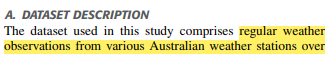

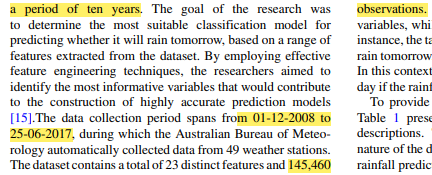

In [3]:
print("from:", data.Date.min(), "to:", data.Date.max())

from: 2007-11-01 to: 2017-06-25


In [4]:
print(len(data))

145460


since its the same length, that was probably a typing error

In [5]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


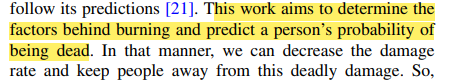

this work was obviously copied from somewhere cuz this project has nothing to do with burning. Researchers do this a lot so I'm not mad at it.

# Data Cleaning

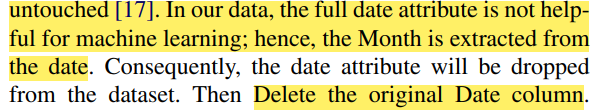

although I do not completely agree, there's nothing wrong with this approach. So let's follow the paper to a T

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

In [7]:
data['Month'] = data['Date'].dt.month

In [8]:
data.drop('Date', inplace=True, axis=1)

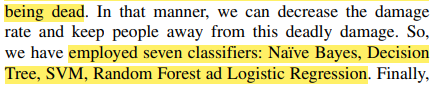

decision tree is my favorite, but dont tell the researcher I said that. Our little secret haha.

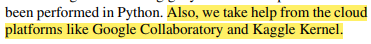

Anything kaggle is a trigger for me, lol. Let's ignore it and use only google colab. With that being said, I'm gonna take the results I see in the paper with a grain of salt.

## outlters

Outliers for each attribute are presented using the boxplot function.

Text(0.5, 1.0, 'Box Plot of Variables')

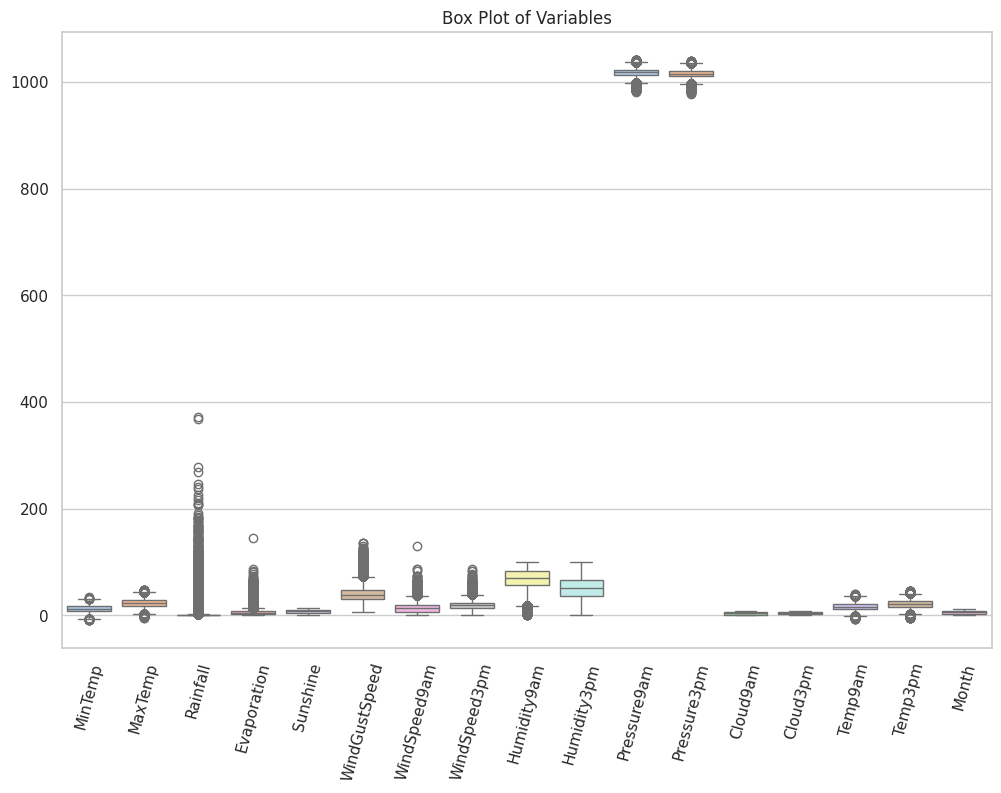

In [9]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

sns.boxplot(data=data, palette="pastel")  # Choose a color palette

# Customize the plot further (adjust as needed)
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.title("Box Plot of Variables")

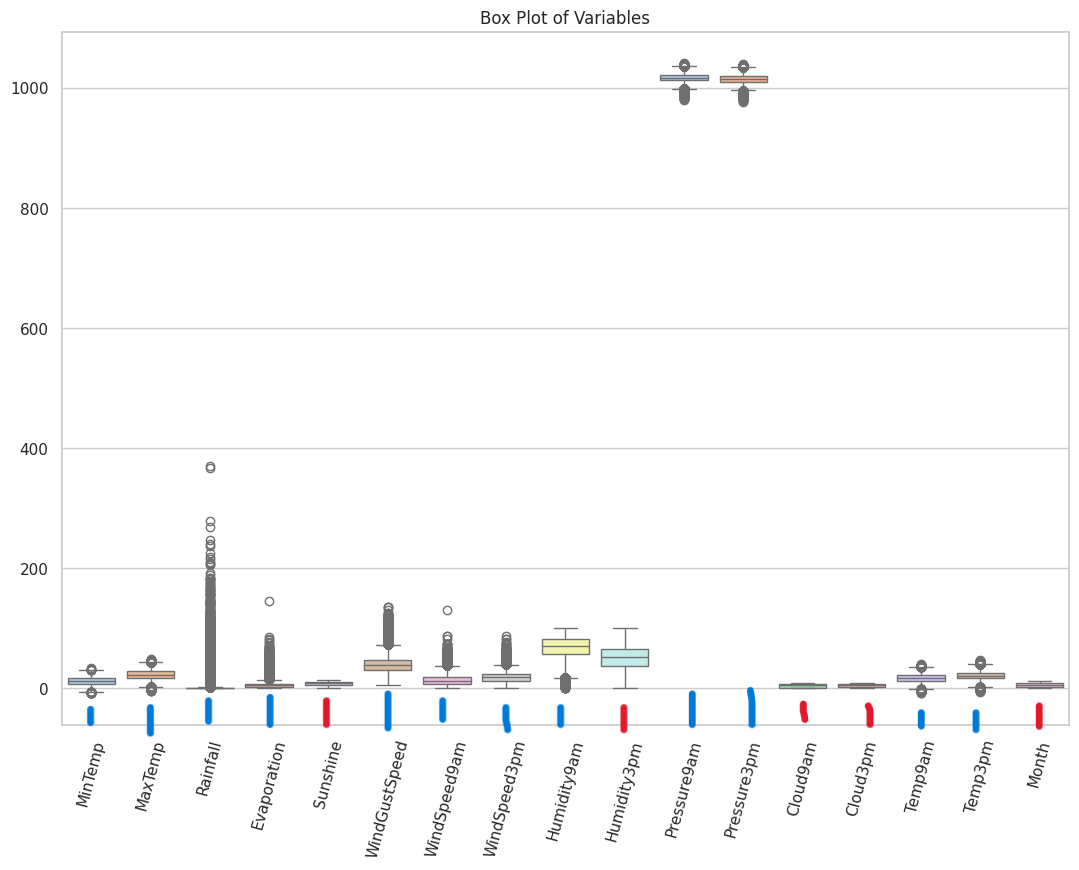

almost all the variables have outliers except those I've marked red do not have outliers

so let us create a list of numeric columns and remove those without outliers so we can focus on the rest

In [10]:
numeric = [col for col in data.columns if data[col].dtype in ['int32', 'int64', 'float64']]
numeric.remove('Sunshine')
numeric.remove('Humidity3pm')
numeric.remove('Cloud9am')
numeric.remove('Cloud3pm')
numeric.remove('Month')

creating histograms to visually assess
whether the distributions exhibit normalcy or skewness.

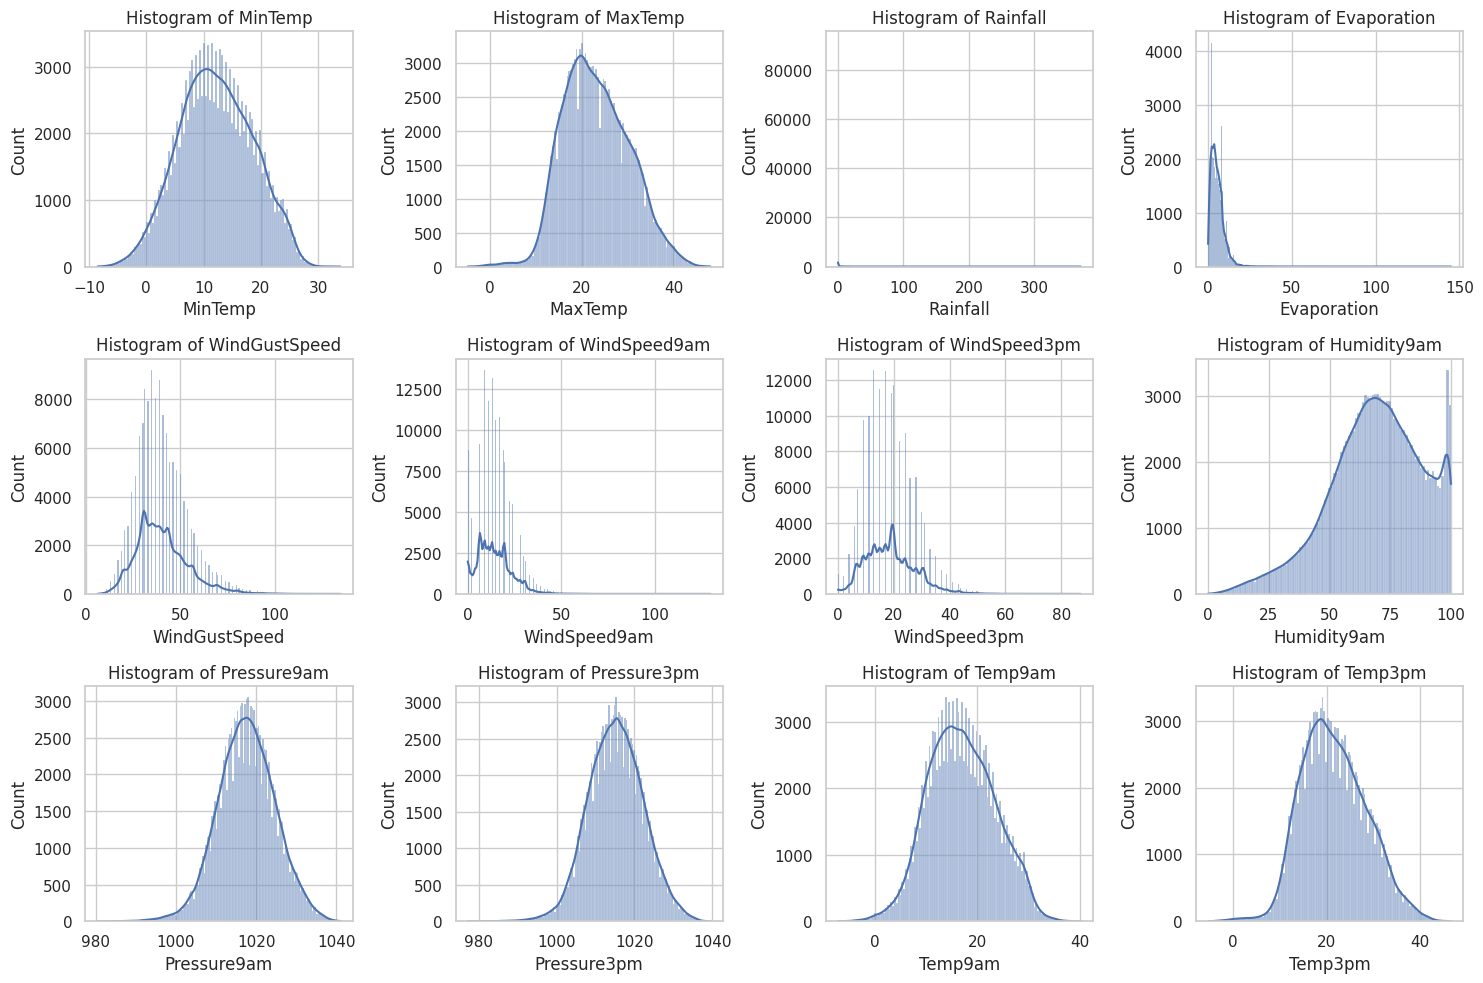

In [11]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(data[numeric].columns) / 4)), ncols=4, figsize=(15, 10))
for i, column in enumerate(data[numeric].columns):
    ax = axes.flatten()[i]
    sns.histplot(data=data, x=column, kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

based on the above plot, the variables with a normal distribution are: MinTemp, MaxTemp, Pressure9am, Pressure3pm, Temp9am and Temp3pm. They all have a bell-shaped curve.

while the rest are skewed

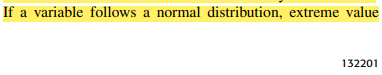

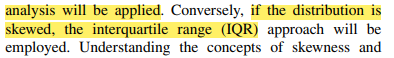

### Extreme Value Analysis (z-score)

Extreme value analysis can be used for datasets that have a normal or gaussian distribution. For those variables with a bell shaped curve, its obvious that most values are close to the mean.

Looking at minTemp for example, most minimum temperature is about 10 degrees. Meaning that the outliers or extreme values are on both ends of the curve, very far away from the mean. Very far from 10.

The z-score is a method that shows you how many standard deviations a data point is from the mean. A very high or low z-score shows that a value is far away from the mean, meaning its an outlier (usually above 3 or below -3).

Z-score is also suitable for small to meduim sized datasets which is what we have here. So let's go ahead and use this method.

In [12]:
variables_of_interest = ['MinTemp', 'MaxTemp', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

# Calculate the z-scores for the variables of interest
z_scores = np.abs((data[variables_of_interest] - data[variables_of_interest].mean()) / data[variables_of_interest].std())

# Set a threshold for detecting outliers (commonly, a z-score > 3 indicates an outlier)
threshold = 3
outliers = z_scores > threshold

# Keep only the rows where no outliers exist in any of the specified variables
data_without_outliers = data[~outliers.any(axis=1)]

In [13]:
len(data_without_outliers)

144304

In [14]:
# Remove the values in variables_of_interest from the numeric list
variables_with_skewed_distribution = [var for var in numeric if var not in variables_of_interest]
variables_with_skewed_distribution

['Rainfall',
 'Evaporation',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am']

### IQR

for these variables, the outliers distort the mean. So we cannot rely on the mean as a refrence to detect outliers. Let's use the Interquartile Range (IQR) method. Here is an example of how it works:

If we have a distribution of heights where the outliers distort the mean, making it skewed to one end, then using the IQR method.

If most people are between 5ft to 6ft tall, then my girlfriend who's 6'3 is an anomaly. (Don't tell her I said that).

the Interquartile Range (IQR) focuses on the middle 50% of the data, instead of comparing to a single mean value.

In [15]:
# # Loop through each variable in variables_with_skewed_distribution
# for col in variables_with_skewed_distribution:
#     # Calculate the 1st and 3rd quartiles (Q1 and Q3)
#     Q1 = data_without_outliers[col].quantile(0.25)
#     Q3 = data_without_outliers[col].quantile(0.75)

#     # Calculate the Interquartile Range (IQR)
#     IQR = Q3 - Q1

#     # Determine the lower and upper bounds for outliers
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Filter the dataset, keeping only the rows where the variable values are within the bounds
#     data_without_outliers = data_without_outliers[(data_without_outliers[col] >= lower_bound) & (data_without_outliers[col] <= upper_bound)]

In [16]:
len(data_without_outliers)

144304

In [17]:
data = data_without_outliers

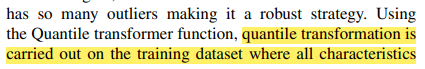

image.png

In [18]:
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64', 'int32']]
numeric_btw_0_1 = [col for col in data[numeric] if data[col].between(0, 1).all()]
numeric_btw_0_1

[]

they didn't choose between IQR and quartile transformation, so I picked quartile since it simply worked better

the code for IQR is commented in a code block above in case you would like to try it yourself

also that part of doing quartile transformation for only numeric variables between 0 and 1 is clearly made up cuz from the above code you can see that no variable like that is in our dataset

this misdirection is probably as a result of the researchers paraphrasing someone else's work

This is what the skewed variables look like before quartile transformation

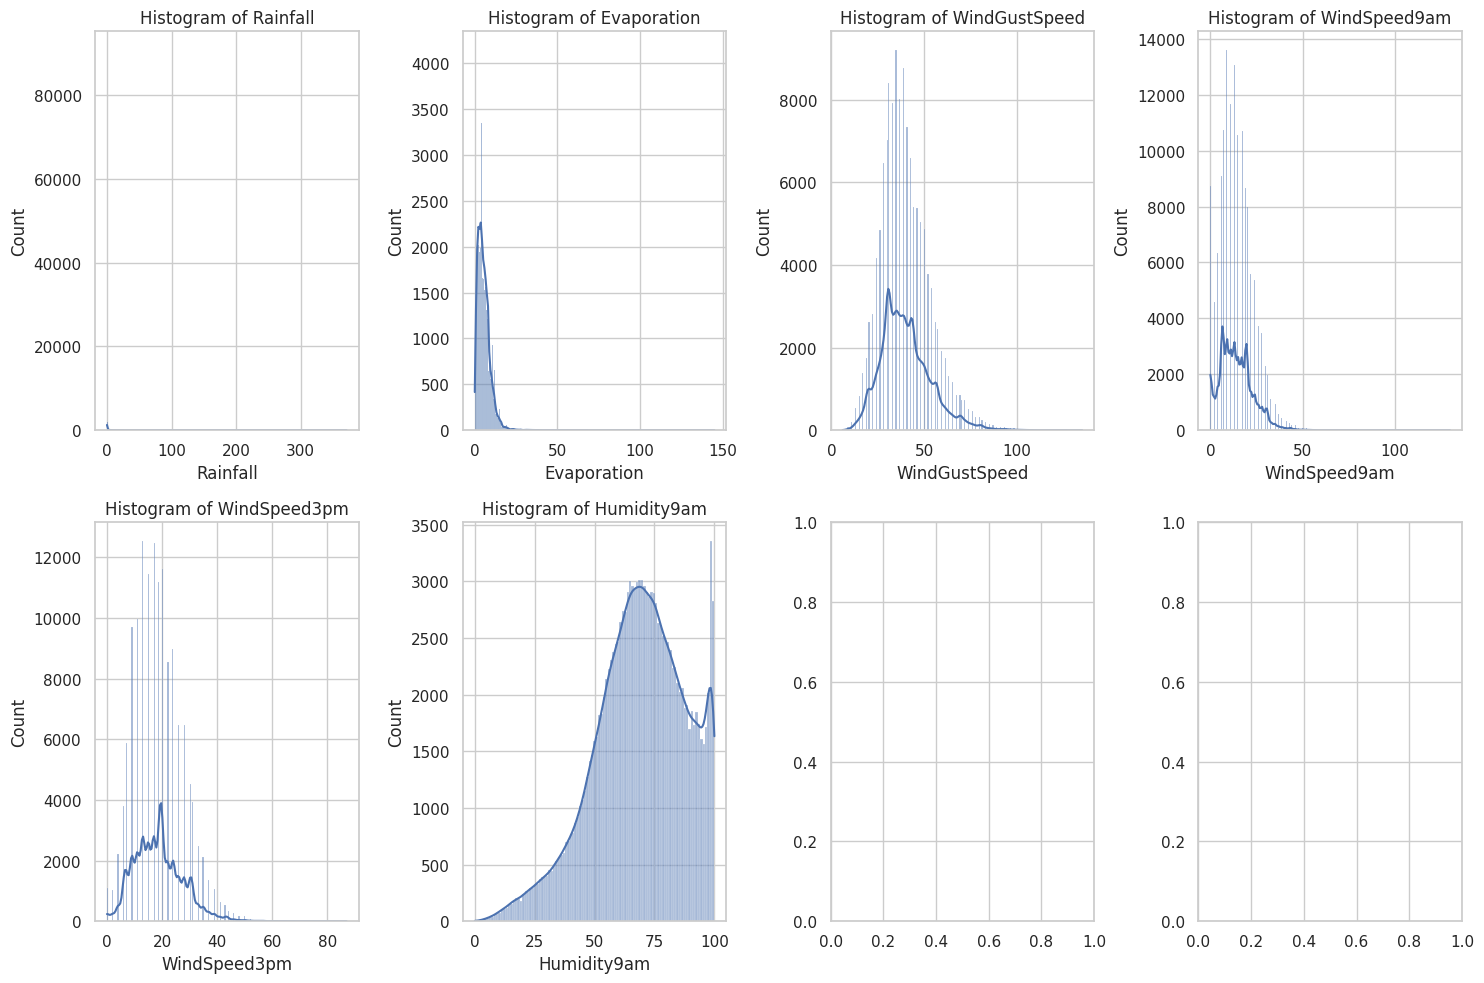

In [19]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(data[variables_with_skewed_distribution].columns) / 4)), ncols=4, figsize=(15, 10))
for i, column in enumerate(data[variables_with_skewed_distribution].columns):
    ax = axes.flatten()[i]
    sns.histplot(data=data, x=column, kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

### Quartile Trasformation

In [20]:
# Quantile Transformation
quantile_transformer = QuantileTransformer(output_distribution='normal')

for col in variables_with_skewed_distribution:
  data[col] = quantile_transformer.fit_transform(data[[col]].values)

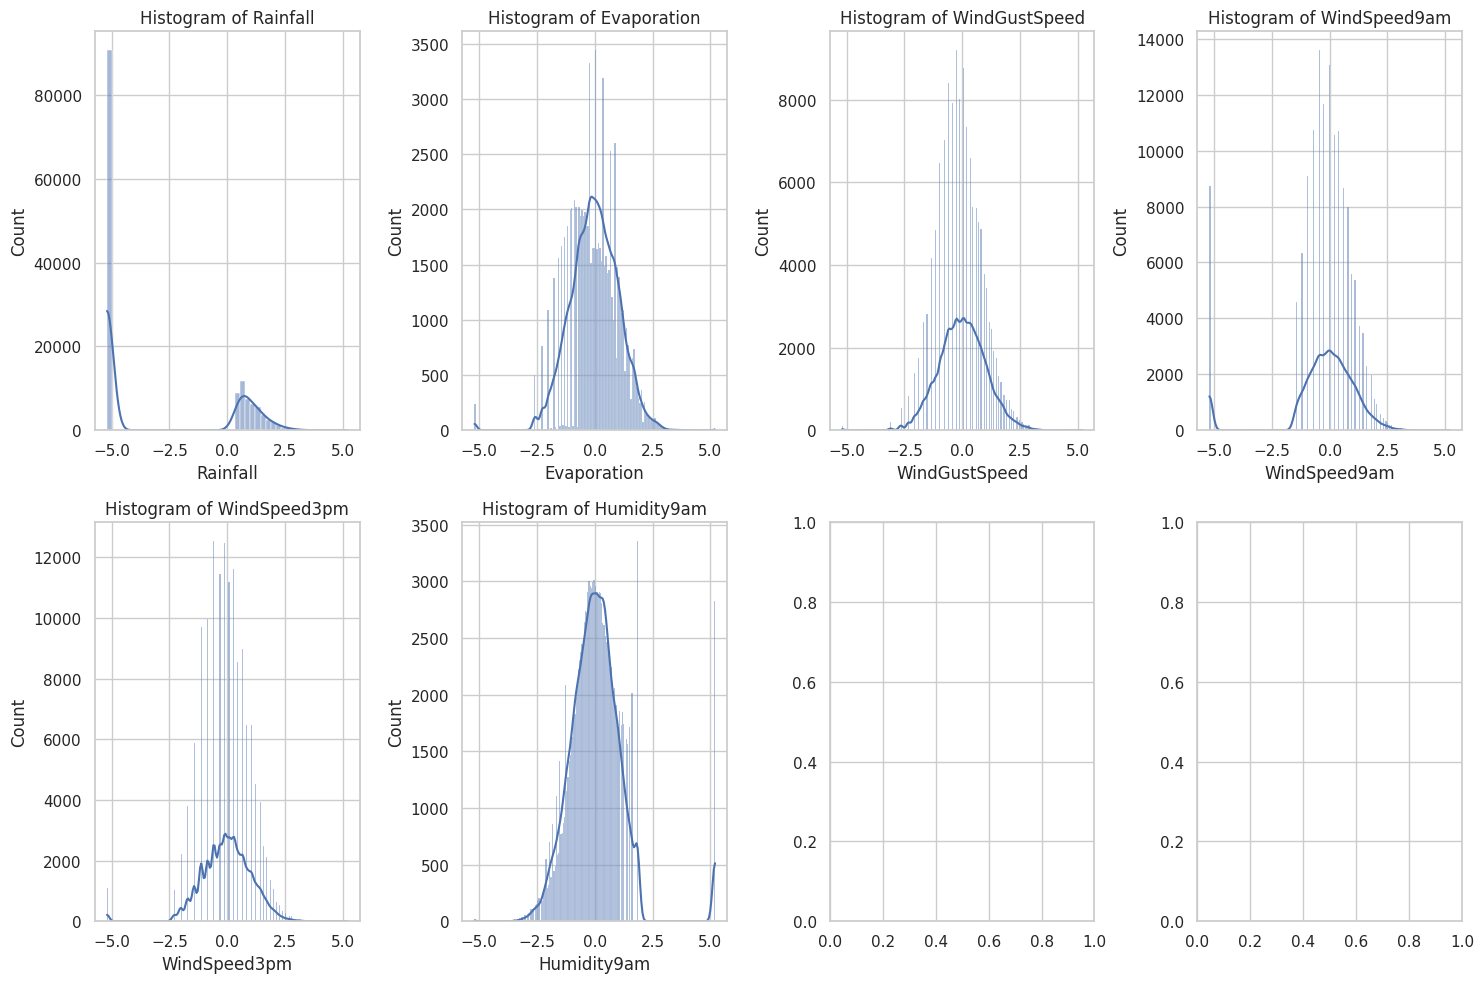

In [21]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(data[variables_with_skewed_distribution].columns) / 4)), ncols=4, figsize=(15, 10))
for i, column in enumerate(data[variables_with_skewed_distribution].columns):
    ax = axes.flatten()[i]
    sns.histplot(data=data, x=column, kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

they now have a bell-shaped curve.

### Drop Duplicates

In [22]:
data.duplicated().sum()

177

let's have a closer look at the duplicates

In [23]:
dup = data.loc[data.duplicated(),:]
dup.head(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
985,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2032,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
3526,BadgerysCreek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5460,BadgerysCreek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
5461,BadgerysCreek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
5843,BadgerysCreek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
5844,BadgerysCreek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
5845,BadgerysCreek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
5846,BadgerysCreek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
5847,BadgerysCreek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12


In [24]:
data.drop_duplicates(inplace=True)

# Exploratory Data Analysis

In [25]:
df = data

descriptive statistics

In [26]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month
count,142832.00000,143050.000000,141042.000000,82145.000000,75133.000000,134113.000000,142575.000000,141274.000000,141719.000000,139846.000000,129599.000000,129635.000000,89075.000000,85620.000000,142602.000000,140740.000000,144127.000000
mean,12.22700,23.278153,-2.968503,-0.016244,7.621413,0.003741,-0.209296,-0.024369,0.052786,51.437095,1017.753210,1015.355429,4.442200,4.504391,17.027793,21.738574,6.397282
std,6.35617,7.007305,3.011406,1.035689,3.782615,1.006287,1.534263,1.073530,1.184859,20.686773,6.923143,6.865870,2.886949,2.720901,6.421852,6.828058,3.429690
min,-7.00000,1.900000,-5.199338,-5.199338,0.000000,-5.199338,-5.199338,-5.199338,-5.199338,0.000000,996.400000,994.200000,0.000000,0.000000,-2.400000,0.900000,1.000000
25%,7.60000,18.000000,-5.199338,-0.697507,4.900000,-0.590949,-0.720087,-0.583496,-0.661162,37.000000,1013.000000,1010.500000,1.000000,2.000000,12.300000,16.700000,3.000000
50%,12.00000,22.700000,-5.199338,0.013801,8.500000,0.069056,-0.020074,0.087933,0.018820,52.000000,1017.700000,1015.300000,5.000000,5.000000,16.700000,21.200000,6.000000
75%,16.90000,28.200000,0.644086,0.699108,10.600000,0.710366,0.583496,0.670557,0.651824,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,9.000000
max,31.00000,44.500000,5.199338,5.199338,14.500000,5.199338,5.199338,5.199338,5.199338,100.000000,1038.900000,1036.300000,9.000000,9.000000,36.400000,42.400000,12.000000


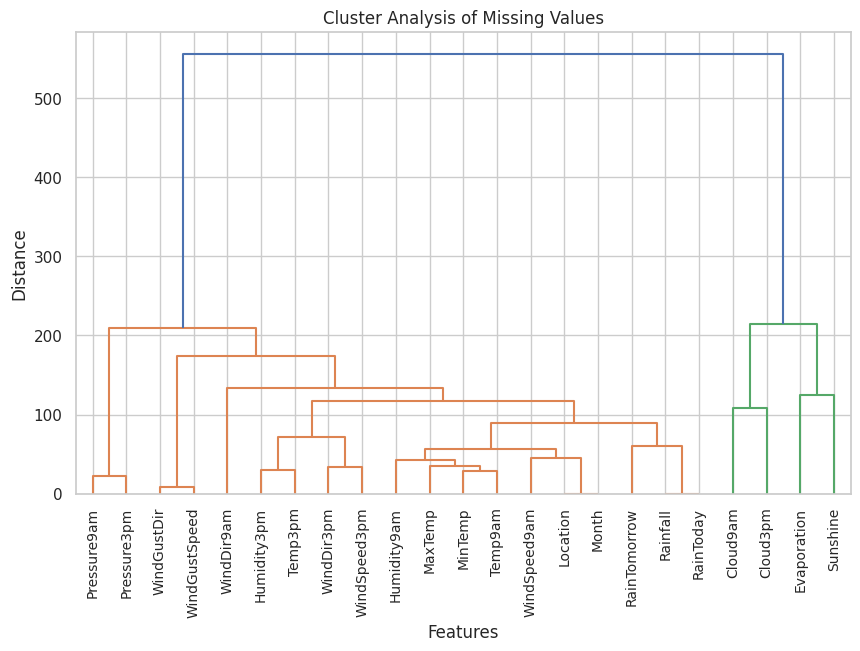

In [27]:
# Convert the missing values into a binary matrix (0: non-missing, 1: missing)
missing_matrix = df.isnull().astype(int).T

# Perform hierarchical clustering using 'ward' method on binary matrix
Z = linkage(missing_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df.columns, leaf_rotation=90)
plt.title('Cluster Analysis of Missing Values')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.show()

The dendogram groups features together in two clusters. The variables in one cluster have similar pattern in how the missing data occurs in the dataset. The closer

The distance of the line represents how much missing values are present. Variables like rainfall and month for example have no missing values.

Later on when we will do feature selection, this diagram will help us select the features that have less missing values, and it will also help us select the variables that have similar patterns of missing values.

variables like "Rain Tomorrow," "Rain Today," "Rainfall," "Date," and "Location," have zero missing values, which is why they are grouped together near the bottom of the dendrogram with shorter branches.

variables like "Humidity 9 am," "Wind Speed 9 am," "Temperature 9 am," "Minimum Temperature," "Maximum Temperature," "Rainfall," "Date," "Rain Tomorrow," and "Rain Today" form a coherent group with minimal missing data. This shows that they have more complete information.

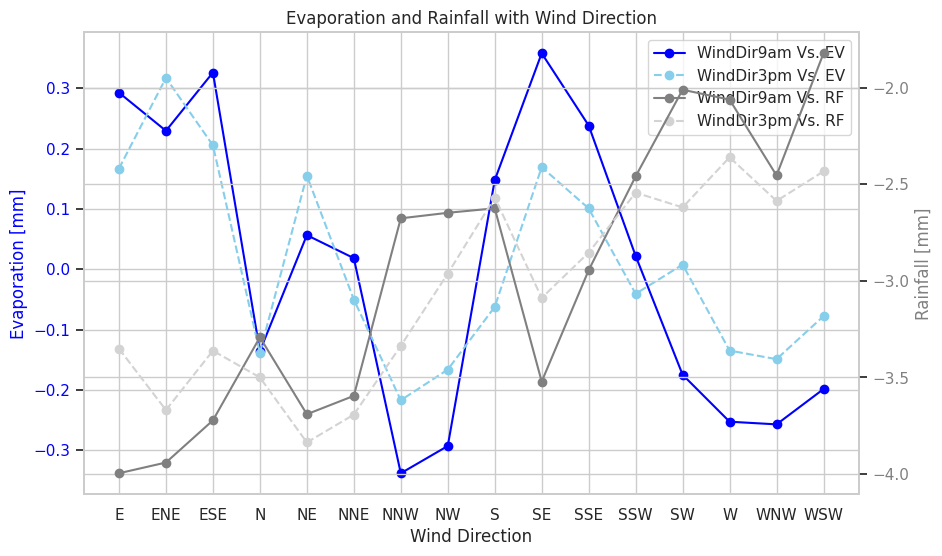

In [28]:
# Drop rows where `Evaporation`, `Rainfall`, `WindDir9am`, or `WindDir3pm` are NaN
df_cleaned = df.dropna(subset=['Evaporation', 'Rainfall', 'WindDir9am', 'WindDir3pm'])

# Group by `WindDir9am` and `WindDir3pm` to get the average Evaporation and Rainfall
# Calculate the mean Evaporation and Rainfall by wind direction
wind_9am_data = df_cleaned.groupby('WindDir9am').agg({
    'Evaporation': 'mean',
    'Rainfall': 'mean'
}).rename(columns={'Evaporation': 'WindDir9am_Evaporation', 'Rainfall': 'WindDir9am_Rainfall'})

wind_3pm_data = df_cleaned.groupby('WindDir3pm').agg({
    'Evaporation': 'mean',
    'Rainfall': 'mean'
}).rename(columns={'Evaporation': 'WindDir3pm_Evaporation', 'Rainfall': 'WindDir3pm_Rainfall'})

# Merge the dataframes on wind directions, fill missing values with NaN if needed
plot_data = pd.concat([wind_9am_data, wind_3pm_data], axis=1)

# Set up the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot WindDir9am vs Evaporation
ax1.plot(plot_data.index, plot_data['WindDir9am_Evaporation'], marker='o', color='blue', linestyle='-', label='WindDir9am Vs. EV')
# Plot WindDir3pm vs Evaporation
ax1.plot(plot_data.index, plot_data['WindDir3pm_Evaporation'], marker='o', color='skyblue', linestyle='--', label='WindDir3pm Vs. EV')
ax1.set_xlabel('Wind Direction')
ax1.set_ylabel('Evaporation [mm]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for Rainfall
ax2 = ax1.twinx()
ax2.plot(plot_data.index, plot_data['WindDir9am_Rainfall'], marker='o', color='gray', linestyle='-', label='WindDir9am Vs. RF')
ax2.plot(plot_data.index, plot_data['WindDir3pm_Rainfall'], marker='o', color='lightgray', linestyle='--', label='WindDir3pm Vs. RF')
ax2.set_ylabel('Rainfall [mm]', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Set the title
plt.title('Evaporation and Rainfall with Wind Direction')
plt.xticks(rotation=45)
plt.show()

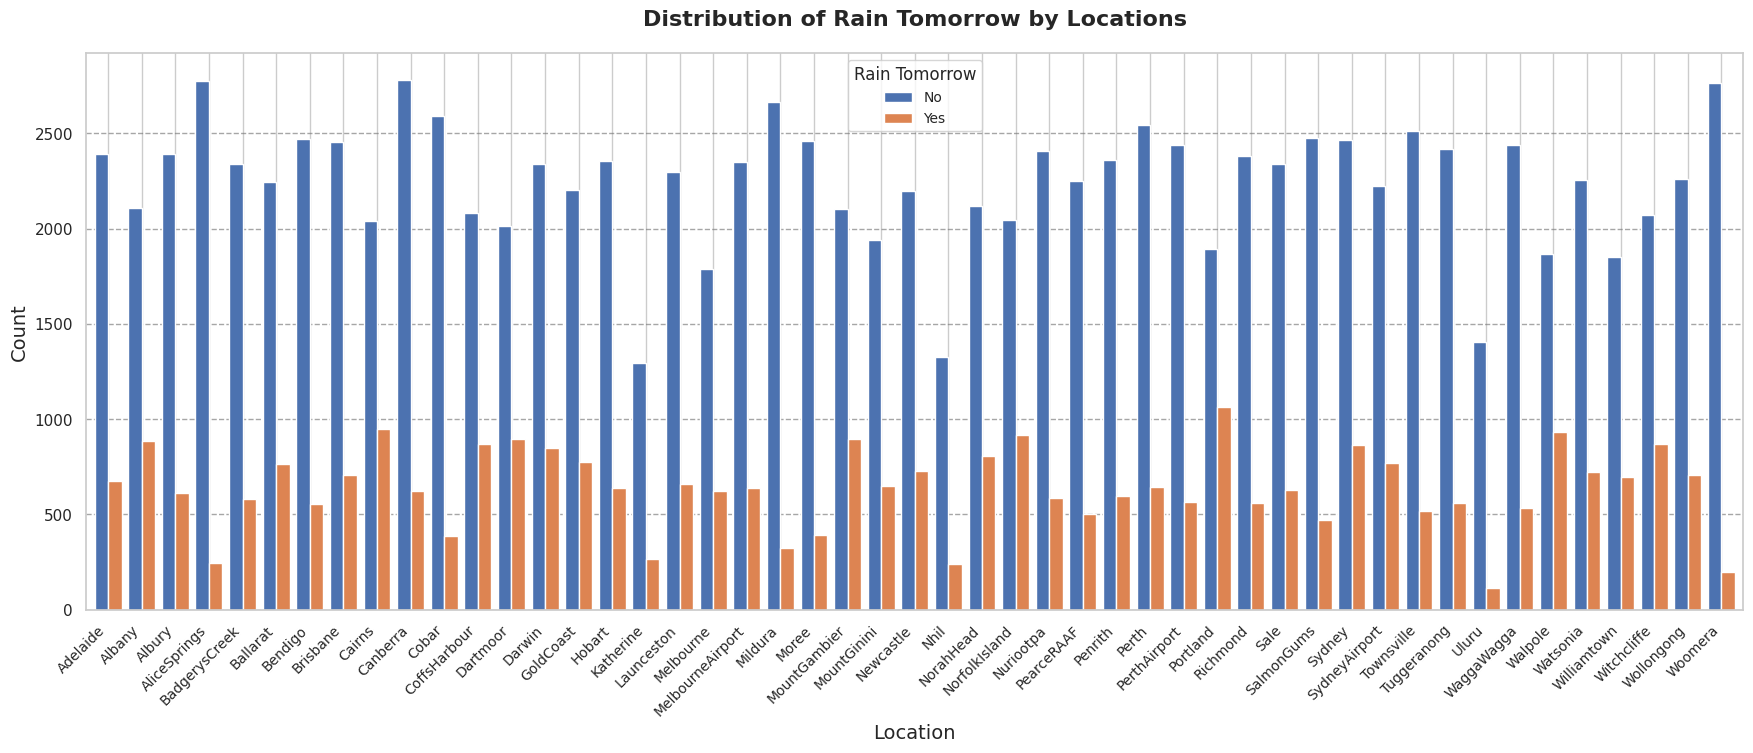

In [29]:
# Set Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Assuming df is already loaded and cleaned (NaN handling, etc.)
df_cleaned = df.dropna(subset=['RainTomorrow', 'Location'])

# Count occurrences of 'Yes' and 'No' in RainTomorrow for each Location
rain_counts = df_cleaned.groupby(['Location', 'RainTomorrow']).size().unstack()

# Plotting
fig, ax = plt.subplots(figsize=(18, 8))  # Larger figure size for better readability

# Define custom colors for "No" and "Yes"
colors = ["#4c72b0", "#dd8452"]  # Soft blue for "No" and warm orange for "Yes"
rain_counts.plot(kind='bar', stacked=False, color=colors, ax=ax, width=0.8)

# Add title and labels with improved font sizes
ax.set_title('Distribution of Rain Tomorrow by Locations', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Location', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Customize x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Add a legend with a clearer title
ax.legend(title='Rain Tomorrow', title_fontsize=12, fontsize=10)

# Add gridlines to the y-axis for easier interpretation
ax.yaxis.grid(True, linestyle='--', color='gray', alpha=0.7)

# Tighten layout and add padding
plt.tight_layout(pad=2)

# Show plot
plt.show()

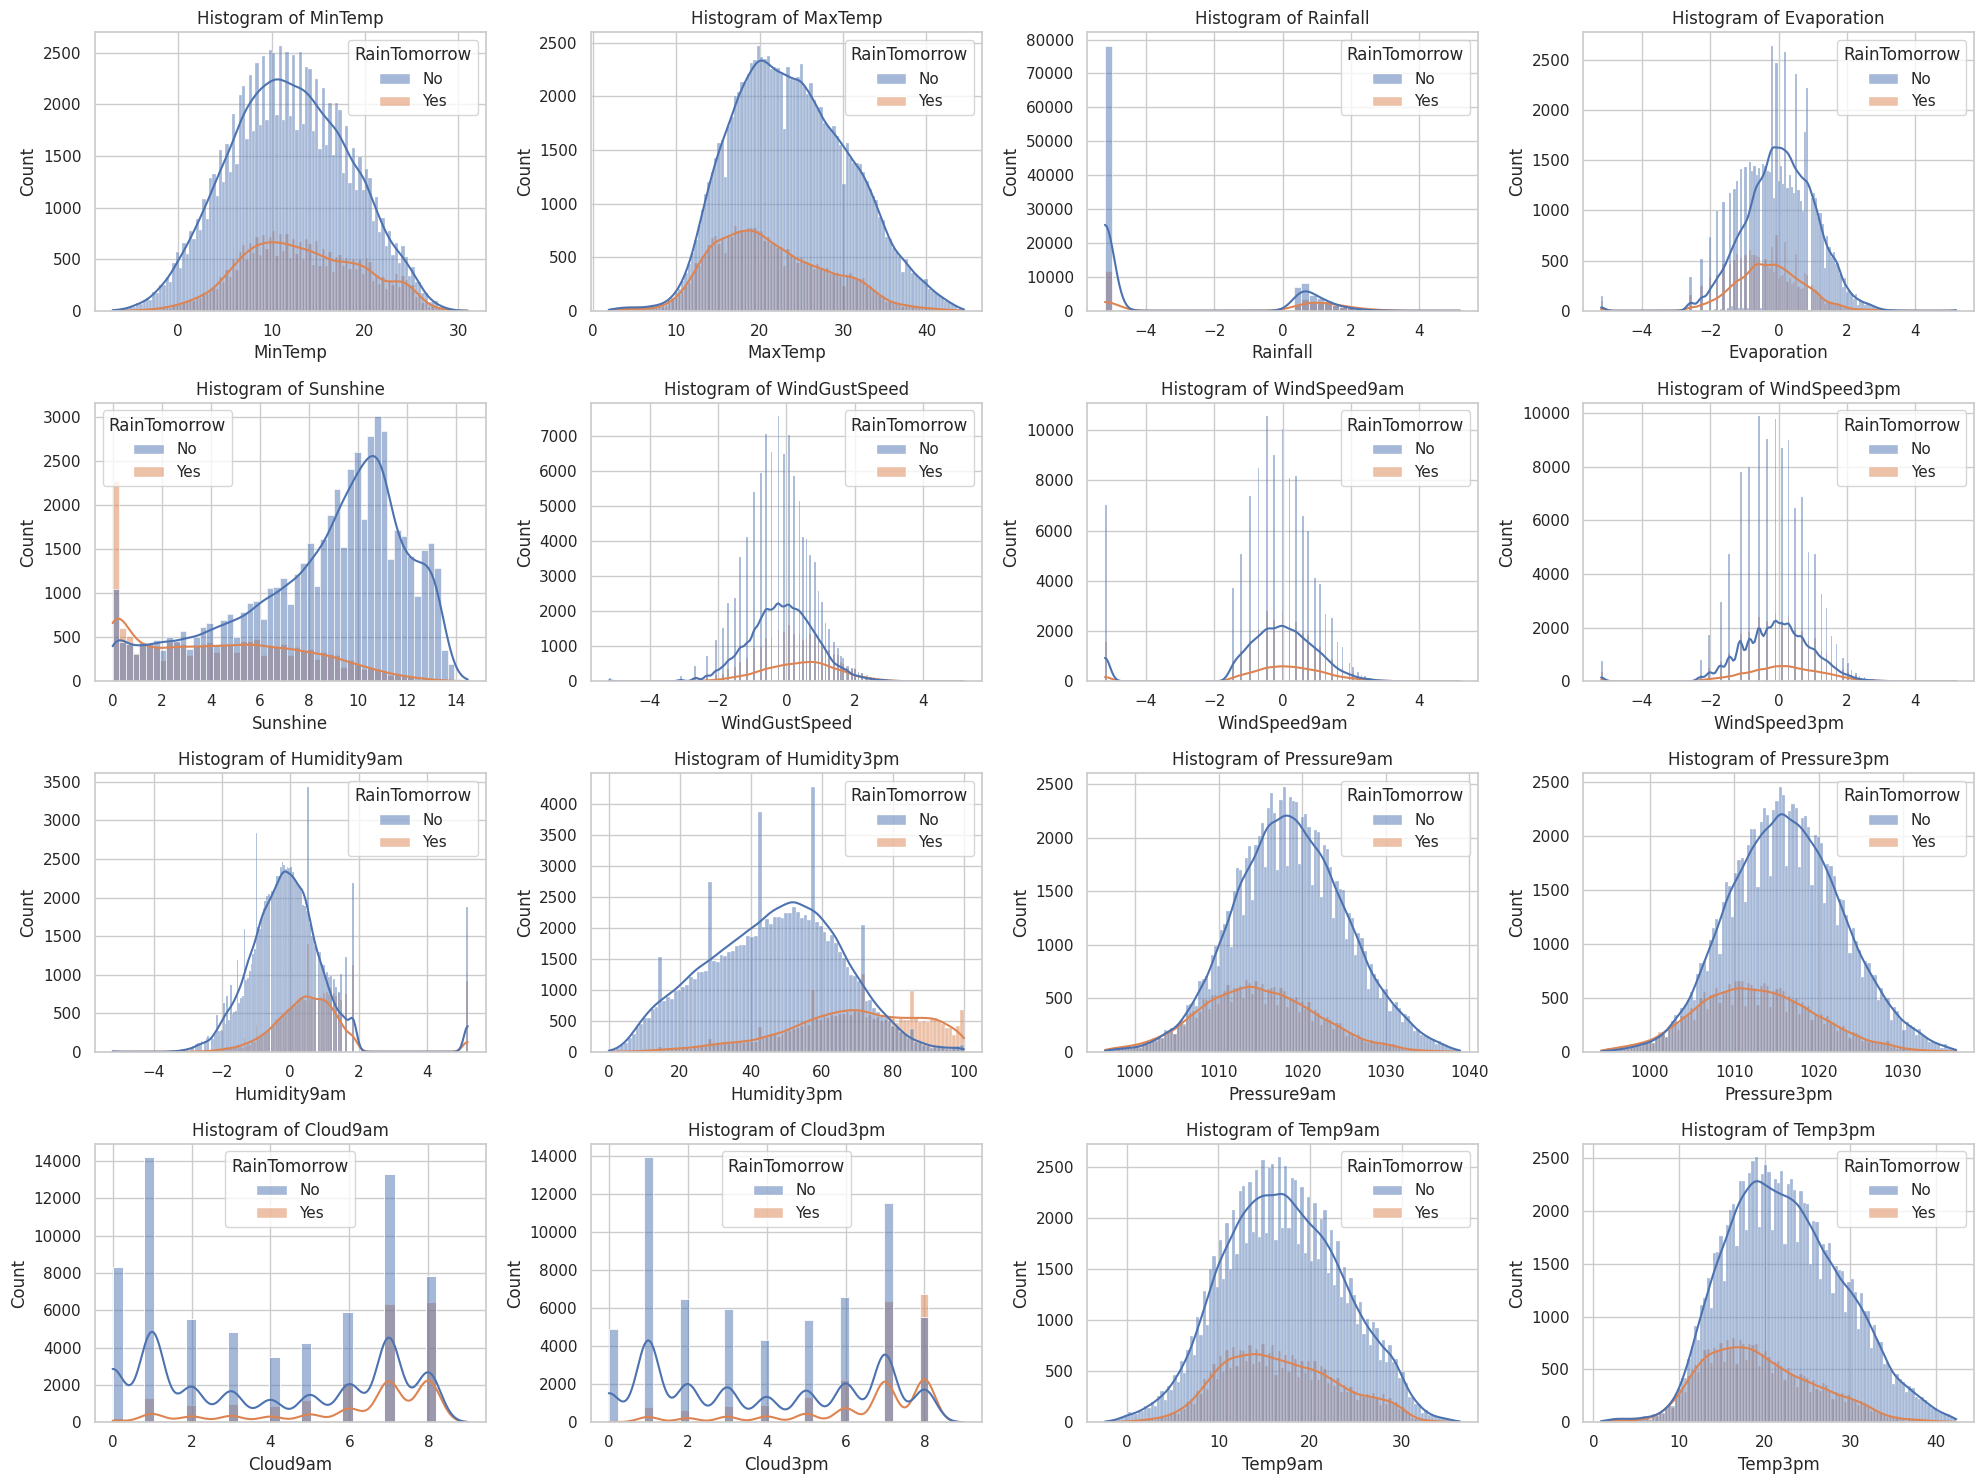

In [30]:
numeric_columns = list(df.select_dtypes(include=['float', 'int']).columns)
numeric_columns.remove('Month')

# Calculate the grid size
n_cols = 4
n_rows = int(np.ceil(len(numeric_columns) / n_cols))

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to easily index axes

# Plot each histogram
for i, column in enumerate(numeric_columns):
    sns.histplot(data=df, x=column, hue='RainTomorrow', alpha=0.5, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Hide any empty subplots (in case number of columns doesn't divide evenly)
for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Higher sunshine and lower humidity correspond with dry days. on the other hand, high humidity low pressure and high cloud coverage in the sky a strong indicators that will rain the next day.

Although there are subtle patterns in the remaining variables like wind speed and temperature, they provide a less clear separation between rainy days and dry days.

We will consider these insights later on during feature selection.

In [31]:
sns.pairplot(df,vars = ['MinTemp', 'MaxTemp', 'Temp3pm', 'Pressure3pm', 'Pressure9am'], hue="RainTomorrow")

MaxTemp and Temp3pm have a strong positive correlation. Same goes for Pressure3pm and Pressure9am.

The screenshot below shows what the researchers had to say about this. I have highlighted it in yellow for your reading pleasure.

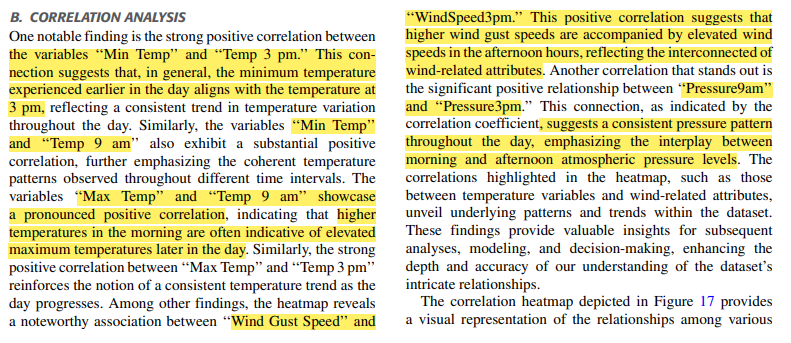

In [ ]:
# correlation heatmap df
plt.figure(figsize=(15, 10))
correlation = df[numeric_columns].corr()
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.show()

let's check with code also

In [ ]:
# Get column pairs with correlation > 0.5
high_corr_pairs = []
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > 0.5:
            high_corr_pairs.append((correlation.columns[i], correlation.columns[j], correlation.iloc[i, j]))

# Check if there are high correlation pairs
if high_corr_pairs:
    # Print column pairs with correlation > 0.5 and their correlation values
    for pair in high_corr_pairs:
        print(pair[0], "-", pair[1], "Correlation:", round(pair[2], 2))
else:
    print("No high correlation columns")

these variables have a very high correlation

# Feature Processing & Engineering

## Impute Missing Values

In [ ]:
data.isnull().sum()

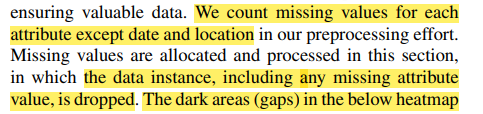

the missing values are to be dropped.

In [ ]:
# Drop the missing rows
data = data.dropna()

In [ ]:
# # Replace missing values: if datatype is int or float, replace with mean; otherwise, replace with the most frequent value
# for column in data.columns:
#     if data[column].dtype in ['object']:
#         data[column].fillna(data[column].mode()[0], inplace=True)
#     else:
#         data[column].fillna(data[column].mean(), inplace=True)

## feature selection

Let us select variables that have a higher feature importance. This was decided after examining the feature importance of the trained model.

In [ ]:
selected_cols = ['Sunshine', 'Humidity3pm', 'Pressure3pm', 'WindGustSpeed', 'Pressure9am', 'Temp9am', 'Humidity9am', 'MinTemp', 'WindSpeed9am', 'Evaporation', 'MaxTemp', 'Rainfall', 'Temp3pm', 'Month', 'WindSpeed3pm', 'Cloud3pm', 'Cloud9am', 'RainToday', 'RainTomorrow']

In [ ]:
# selected_cols = ["Humidity3pm", "WindGustSpeed", "Sunshine", "MaxTemp", "Temp3pm", "Pressure3pm", "Location", "WindDir3pm", "WindDir9am", "WindSpeed3pm", 'RainToday', 'RainTomorrow']

In [ ]:
data = data[selected_cols]

# Features Encoding

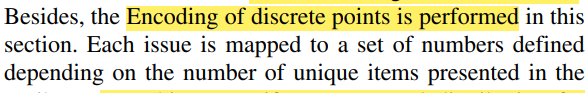

refering to the screenshot above, we'll encode the categoric variables here

In [ ]:
categoric = [col for col in data.columns if data[col].dtype == 'object']
print("categoric_cols:", categoric)

In [ ]:
print("categoric_col", "-", "num_unique_values")
for col in categoric:
    print(col, "-", data[col].nunique())

ordinal encoding is suitable for variables that have a meaningful order, like small, medium, large. Directions like North, East, West, South do not have a specific order.

therefore, let us use one-hot encoder for them since it treats direction as independent, which fits the nature of these variables.

same applies for location

as for "RainToday" and "RainTomorrow", we'll encode "yes" as 1 and "no" as 0.

In [42]:
data['RainToday'] = data['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)
data['RainTomorrow'] = data['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

In [43]:
categoric.remove("RainTomorrow")
categoric.remove("RainToday")

In [44]:
# calling our encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first")
# setting output to DataFrame
encoder.set_output(transform="pandas")
# encoding our data
cat_encoded = encoder.fit_transform(data[categoric])

In [45]:
numeric = [col for col in data.columns if data[col].dtype in ['int32', 'int64', 'float64']]
print("numeric_cols:", numeric)

numeric_cols: ['Sunshine', 'Humidity3pm', 'Pressure3pm', 'WindGustSpeed', 'Pressure9am', 'Temp9am', 'Humidity9am', 'MinTemp', 'WindSpeed9am', 'Evaporation', 'MaxTemp', 'Rainfall', 'Temp3pm', 'Month', 'WindSpeed3pm', 'Cloud3pm', 'Cloud9am', 'RainToday', 'RainTomorrow']


In [46]:
data = pd.concat([cat_encoded, data[numeric]], axis=1)

In [47]:
data.head()

,Sunshine,Humidity3pm,Pressure3pm,WindGustSpeed,Pressure9am,Temp9am,Humidity9am,MinTemp,WindSpeed9am,Evaporation,MaxTemp,Rainfall,Temp3pm,Month,WindSpeed3pm,Cloud3pm,Cloud9am,RainToday,RainTomorrow
6049,12.3,13.0,1004.4,0.710366,1006.3,26.6,-2.211127,17.9,-0.961429,1.625274,35.2,-5.199338,33.4,1,0.287442,5.0,2.0,0,0
6050,13.0,8.0,1012.1,-0.089192,1012.9,20.3,-1.831224,18.4,0.583496,1.968165,28.9,-5.199338,27.0,1,0.087933,1.0,1.0,0,0
6052,10.6,22.0,1009.2,0.592444,1012.3,28.7,-1.355761,19.4,1.606755,1.397837,37.6,-5.199338,34.9,1,-0.332198,6.0,1.0,0,0
6053,12.2,22.0,1009.1,-0.590949,1012.7,29.1,-1.558482,21.9,-0.961429,1.501861,38.4,-5.199338,35.6,1,-1.716415,5.0,1.0,0,0
6054,8.4,15.0,1007.4,-0.253606,1010.7,33.6,-2.256745,24.2,0.387078,1.467860,41.0,-5.199338,37.6,1,-0.583496,6.0,1.0,0,0


# Dataset Splitting

In [48]:
X = data.drop('RainTomorrow', axis=1)
y = data['RainTomorrow']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [50]:
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((44871, 18), (11218, 18), (44871,), (11218,))

# Features Scaling


In [51]:
# Scaler = StandardScaler().fit(X_train[numeric]).set_output(transform="pandas")

# X_numScaled_train = Scaler.transform(X_train[numeric])
# X_numScaled_test = Scaler.transform(X_test[numeric])

In [52]:
# X_train = pd.concat([X_numScaled_train, X_catEncoded_train], axis=1)
# X_test = pd.concat([X_numScaled_test, X_catEncoded_test], axis=1)

## Data Imbalance Check

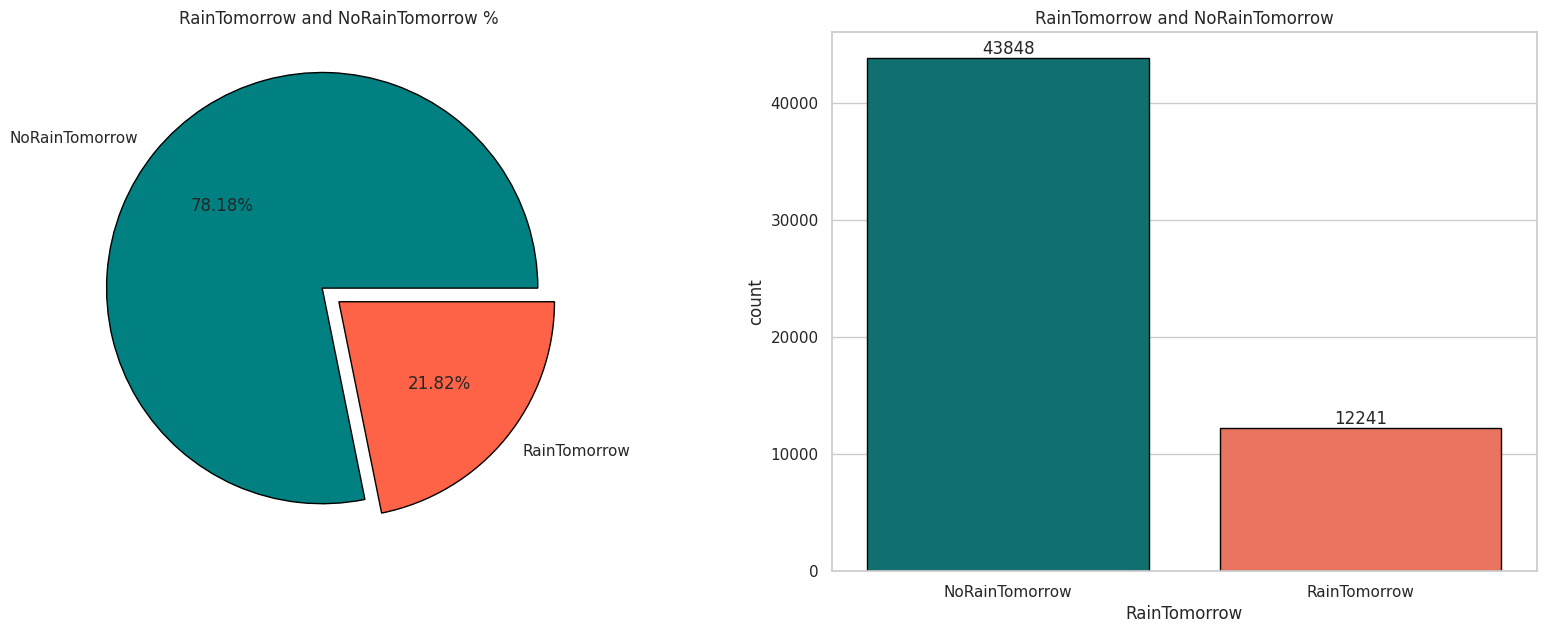

In [53]:
#Defining colors for the plots
palette = ['#008080','#FF6347', '#E50000', '#D2691E']
palette2 = ['#FF6347', '#008080', '#E50000', '#D2691E']

l1 = list(data['RainTomorrow'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['NoRainTomorrow','RainTomorrow'],
        autopct = '%1.2f%%',
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('RainTomorrow and NoRainTomorrow %');

plt.subplot(1,2,2)
ax = sns.countplot(data = data,
                   x='RainTomorrow',
                   palette = palette,
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['NoRainTomorrow','RainTomorrow'])

plt.title('RainTomorrow and NoRainTomorrow')
plt.show()


Dataset is imbalanced. Only 21.82% of cases in the dataset are indicating "RainTomorrow" (indicating it will rain the next day).

This means that a blind guess predicting "No Rain Tomorrow" for all cases would give us an accuracy of 78.18%.

Therefore, we can't use Accuracy Score to choose our model

what to do to solve this issue? We will use random over sampling method to create balance.

the researchers did not use any method to balance the dataset. They just left it like that which I completely disagree with. What is the point of even checking if you still plan on leaving it imbalanced?

In [54]:
#Oversampling the minority class (RainTomorrow)
ros = RandomOverSampler(random_state=0)
X_new,y_new= ros.fit_resample(X_train, y_train)

print("After Random Over Sampling Of Minor Class Total Samples are :", len(y_new))
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))

After Random Over Sampling Of Minor Class Total Samples are : 70212
Original dataset shape Counter({0: 43848, 1: 12241})
Resampled dataset shape Counter({1: 35106, 0: 35106})


In [55]:
X_train, y_train = X_new,y_new

Now our data is balanced, 1 reprents RinTomorrow while 0 represents noRainTomorrow

# Machine Learning Modeling


## 1.  Logistic Regression

### Create the Model

In [56]:
model= LogisticRegression()

### Train the Model

In [57]:
model=model.fit(X_train, y_train)


###  Predict on the test dataset

In [58]:
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]


### Model Evaluation

In [59]:
r_lgt= recall_score(y_test, pred)
print("recall_score : ", r_lgt)

p_lgt= precision_score(y_test, pred)
print("precision_score :",p_lgt)

f1_lgt= f1_score(y_test, pred)
print("f1_score :", f1_lgt)

f2_lgt = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score :", f2_lgt)

A_lgt= accuracy_score(pred, y_test)
print("accuracy_score :",A_lgt)

acu_lgt = roc_auc_score(pred, y_test)
print("ROC_AUC Score:",acu_lgt)


recall_score :  0.781502423263328
precision_score : 0.5114988104678826
f1_score : 0.6183096341268574
f2_score : 0.7068751369913057
accuracy_score : 0.7870386878231413
ROC_AUC Score: 0.7193674280987699


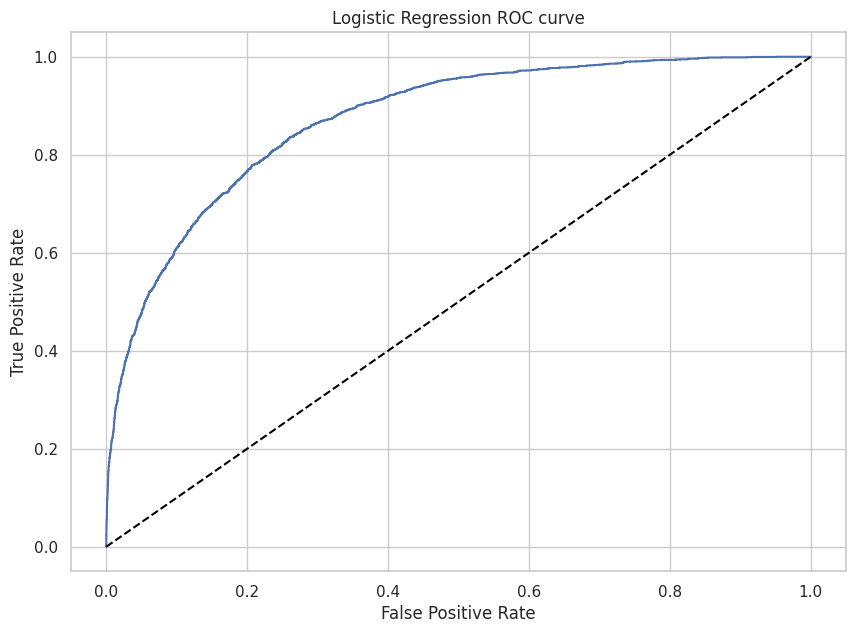

In [60]:
# plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Logistic Regression ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

##  6. DecisionTreeClassifier

### Create the Model

In [61]:
dtmodel = DecisionTreeClassifier()

### Train the Model

In [62]:
dtmodel = dtmodel.fit(X_train, y_train)

### Predict on the test dataset

In [63]:
dt_pred = dtmodel.predict(X_test)
dt_prob = dtmodel.predict_proba(X_test)[:,1]

### Model Evaluation

In [64]:
r_dt= recall_score(y_test, dt_pred)
print("recall_score : ", r_dt)

p_dt= precision_score(y_test, dt_pred)
print("precision_score :",p_dt)

f1_dt= f1_score(y_test, dt_pred)
print("f1_score :", f1_dt)

f2_dt = fbeta_score(y_test, dt_pred, beta=2, average='binary')
print("f2_score :", f2_dt)


A_dt= accuracy_score( y_test, dt_pred)
print("accuracy_score :", A_dt)

acu_dt = roc_auc_score(dt_pred, y_test)
print("ROC_AUC Score:",acu_dt)

recall_score :  0.5262520193861067
precision_score : 0.5431429762401
f1_score : 0.5345641025641026
f2_score : 0.5295456392749736
accuracy_score : 0.7977357817792833
ROC_AUC Score: 0.7050673493288038


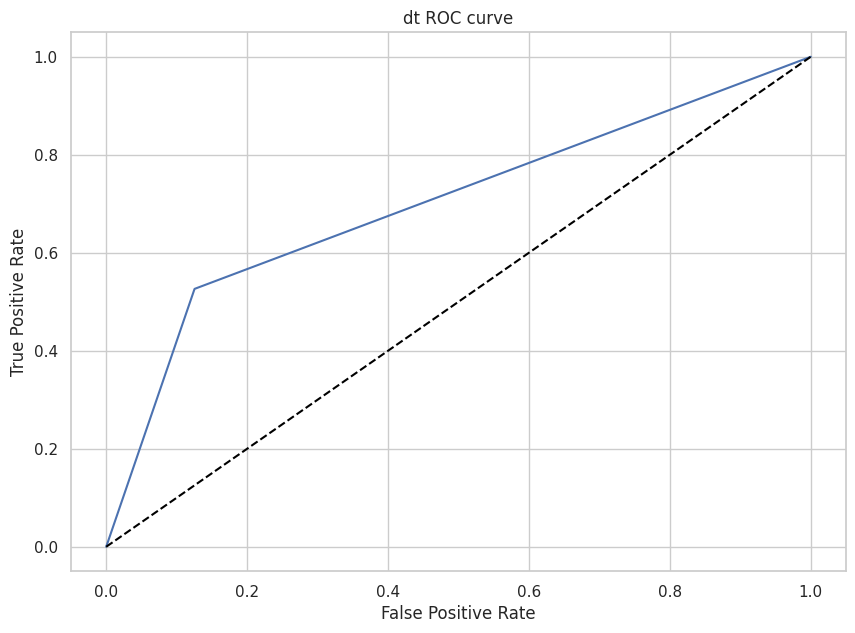

In [65]:
#  plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, dt_prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('dt ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

## RandomForestClassifier

In [66]:
# Define and fit the Random Forest model
model = RandomForestClassifier()
model = model.fit(X_train, y_train)

# Make predictions
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:, 1]

# Calculate recall
r_rf = recall_score(y_test, pred)
print("recall_score:", r_rf)

# Calculate precision
p_rf = precision_score(y_test, pred)
print("precision_score:", p_rf)

# Calculate F1 score
f1_rf = f1_score(y_test, pred)
print("f1_score:", f1_rf)

# Calculate F2 score
f2_rf = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score:", f2_rf)

# Calculate accuracy
A_rf = accuracy_score(y_test, pred)
print("accuracy_score:", A_rf)

# Calculate ROC AUC score
acu_rf = roc_auc_score(y_test, prob)
print("ROC_AUC Score:", acu_rf)

recall_score: 0.6122778675282714
precision_score: 0.7067599067599067
f1_score: 0.6561350357065571
f2_score: 0.6290978504440202
accuracy_score: 0.8583526475307541
ROC_AUC Score: 0.8943879315092239


## Support Vector Machine (SVM)

In [67]:
# from sklearn.svm import SVC

# # Define and fit the SVM model with probability estimates enabled
# model = SVC(probability=True)
# model = model.fit(X_train, y_train)

# # Make predictions
# pred = model.predict(X_test)
# prob = model.predict_proba(X_test)[:, 1]

# # Calculate recall
# r_svm = recall_score(y_test, pred)
r_svm = 0
# print("recall_score:", r_svm)

# # Calculate precision
# p_svm = precision_score(y_test, pred)
p_svm = 0
# print("precision_score:", p_svm)

# # Calculate F1 score
# f1_svm = f1_score(y_test, pred)
f1_svm = 0
# print("f1_score:", f1_svm)

# # Calculate F2 score
# f2_svm = fbeta_score(y_test, pred, beta=2, average='binary')
f2_svm = 0
# print("f2_score:", f2_svm)

# # Calculate accuracy
# A_svm = accuracy_score(y_test, pred)
A_svm = 0
# print("accuracy_score:", A_svm)

# # Calculate ROC AUC score
# acu_svm = roc_auc_score(y_test, prob)
acu_svm = 0
# print("ROC_AUC Score:", acu_svm)

## Artificial Neural Network (ANN)

In [68]:
# Define the ANN ann_model
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))

# Compile the ann_model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the ann_model
ann_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Make predictions
pred = (ann_model.predict(X_test) > 0.5).astype("int32").flatten()
prob = ann_model.predict(X_test).flatten()

# Calculate recall
r_ann = recall_score(y_test, pred)
print("recall_score:", r_ann)

# Calculate precision
p_ann = precision_score(y_test, pred)
print("precision_score:", p_ann)

# Calculate F1 score
f1_ann = f1_score(y_test, pred)
print("f1_score:", f1_ann)

# Calculate F2 score
f2_ann = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score:", f2_ann)

# Calculate accuracy
A_ann = accuracy_score(y_test, pred)
print("accuracy_score:", A_ann)

# Calculate ROC AUC score
acu_ann = roc_auc_score(y_test, prob)
print("ROC_AUC Score:", acu_ann)

Epoch 1/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6944 - loss: 3.2659
Epoch 2/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7499 - loss: 0.5713
Epoch 3/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7588 - loss: 0.5466
Epoch 4/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7626 - loss: 0.5324
Epoch 5/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7637 - loss: 0.5157
Epoch 6/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7723 - loss: 0.4976
Epoch 7/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7681 - loss: 0.5052
Epoch 8/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7754 - loss: 0.4799
Epoch 9/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7795 - loss: 0.4677
Epoch 10/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7793 - loss: 0.4659
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
recall_score: 0.9559773828756059
prec

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score, roc_auc_score

# Define and fit the Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:, 1]

# Calculate recall
r_nb = recall_score(y_test, pred)
print("recall_score:", r_nb)

# Calculate precision
p_nb = precision_score(y_test, pred)
print("precision_score:", p_nb)

# Calculate F1 score
f1_nb = f1_score(y_test, pred)
print("f1_score:", f1_nb)

# Calculate F2 score
f2_nb = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score:", f2_nb)

# Calculate accuracy
A_nb = accuracy_score(y_test, pred)
print("accuracy_score:", A_nb)

# Calculate ROC AUC score
acu_nb = roc_auc_score(y_test, prob)
print("ROC_AUC Score:", acu_nb)


## LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score, roc_auc_score
import numpy as np

# Reshape data for LSTM input (samples, timesteps, features)
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

# Make predictions
pred = (model.predict(X_test_lstm) > 0.5).astype("int32").flatten()
prob = model.predict(X_test_lstm).flatten()

# Calculate recall
r_lstm = recall_score(y_test, pred)
print("recall_score:", r_lstm)

# Calculate precision
p_lstm = precision_score(y_test, pred)
print("precision_score:", p_lstm)

# Calculate F1 score
f1_lstm = f1_score(y_test, pred)
print("f1_score:", f1_lstm)

# Calculate F2 score
f2_lstm = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score:", f2_lstm)

# Calculate accuracy
A_lstm = accuracy_score(y_test, pred)
print("accuracy_score:", A_lstm)

# Calculate ROC AUC score
acu_lstm = roc_auc_score(y_test, prob)
print("ROC_AUC Score:", acu_lstm)


# Models comparison

since missing rainfall events is more costly, false negatives are more important.

false negatives occur when the model predicts no rain, but rain actually falls. Unexpected rainfall on your wedding day is problematic, so we will evaluate our model based on metrics that prioritize false negatives.

f2 score and recall both emphasize false negatives, so this is the perfect choice. We can't use accuracy as a metric because our dataset is imbalanced, and we had to resample it.

ROC score is also a good balanced metric so we may use that as well.

meaning all that yapping they did in the research paper about other metrics, I really think they either copied it from somewhere, or the wrote it there to fill white space, and meet the required word count for the paper.

### before feature selection

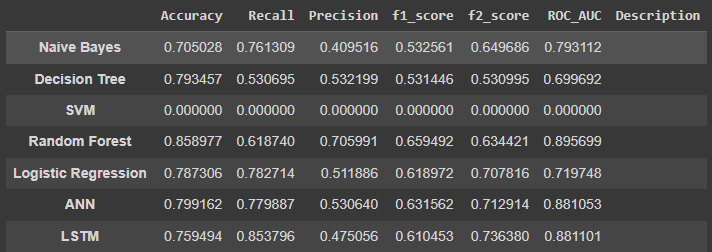

### after feature selection

In [71]:
# List of models for comparison
compare_models = ['Naive Bayes', 'Decision Tree', 'SVM', 'Random Forest', 'Logistic Regression', 'ANN', 'LSTM']

# Dictionary of results
data_compare = {
    'Accuracy': [A_nb, A_dt, A_svm, A_rf, A_lgt, A_ann, A_lstm],
    'Recall': [r_nb, r_dt, r_svm, r_rf, r_lgt, r_ann, r_lstm],
    'Precision': [p_nb, p_dt, p_svm, p_rf, p_lgt, p_ann, p_lstm],
    'f1_score': [f1_nb, f1_dt, f1_svm, f1_rf, f1_lgt, f1_ann, f1_lstm],
    'f2_score': [f2_nb, f2_dt, f2_svm, f2_rf, f2_lgt, f2_ann, f2_lstm],
    'ROC_AUC': [acu_nb, acu_dt, acu_svm, acu_rf, acu_lgt, acu_ann, acu_lstm],
    'Description': ['', '', '', '', '', '', '']
}

# Create DataFrame with the comparison results
result = pd.DataFrame(data=data_compare, index=compare_models)
result


,Accuracy,Recall,Precision,f1_score,f2_score,ROC_AUC,Description
Naive Bayes,0.753521,0.771405,0.464833,0.580106,0.681510,0.844586,
Decision Tree,0.797736,0.526252,0.543143,0.534564,0.529546,0.705067,
SVM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,
Random Forest,0.858353,0.612278,0.706760,0.656135,0.629098,0.894388,
Logistic Regression,0.787039,0.781502,0.511499,0.618310,0.706875,0.719367,
ANN,0.599483,0.955977,0.350615,0.513059,0.710597,0.874522,
LSTM,0.693172,0.910339,0.411765,0.567044,0.732865,0.873932,


Recall measures the ability to identify if rain will actually fall (minimizing false negatives), while the f2_score places more emphasis on recall compared to precision.


Based on the above metrics, **ANN is the best model** for this rainfall detection project as it has the highest recall (0.95) and a high f2_score (0.71), indicating it is effective in detecting rainfall while minimizing false negatives (minimizing cases where it predicted no rain and rain still fell).

In the context of rainfall prediction, ROC_AUC is important because it gives a holistic view of the model's performance across all classification thresholds.

Based on the ROC_AUC values and previously discussed metrics (recall and f2_score), the ANN model stands out as the best model for this rainfall prediction project with the 2nd highest ROC_AUC (0.87).

# k-Fold cross validation

## ANN

In [79]:
# Define the custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# Define the ANN model-building function
def build_ann():
    ann_model = Sequential()
    ann_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    ann_model.add(Dense(32, activation='relu'))
    ann_model.add(Dense(1, activation='sigmoid'))
    ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return ann_model

# Custom function to handle cross-validation for the Keras model
def cross_val_f2_score(model_builder, X, y, cv, scorer):
    scores = []
    for train_idx, val_idx in cv.split(X):
        # Build and train the model
        model = model_builder()
        model.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)

        # Generate predictions and evaluate F2 score
        predictions = (model.predict(X[val_idx]) > 0.5).astype(int)
        score = scorer._score_func(y[val_idx], predictions, beta=2)
        scores.append(score)
    return scores

# Set up 5-fold cross-validation
ann_fold = KFold(n_splits=5, shuffle=True)

# Calculate F2 scores for each fold
scores = cross_val_f2_score(build_ann, X_train.values, y_train.values, cv=ann_fold, scorer=f2_scorer)
ann_cv_score = np.mean(scores)
ann_cv_stdev = stdev(scores)

print('Cross Validation F2 scores are: {}'.format(scores))
print('Average Cross Validation F2 score: ', ann_cv_score)
print('Cross Validation F2 standard deviation: ', ann_cv_stdev)

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Cross Validation F2 scores are: [0.7338315691520297, 0.8605935875216638, 0.8487662801560697, 0.8258057321289172, 0.786918389429922]
Average Cross Validation F2 score:  0.8111831116777205
Cross Validation F2 standard deviation:  0.05157457848039865


after evaluation with KFold cross validation,

our model maintains its high performance

# Feature Importance

# ANN

before feature selection:

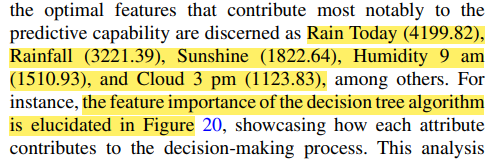

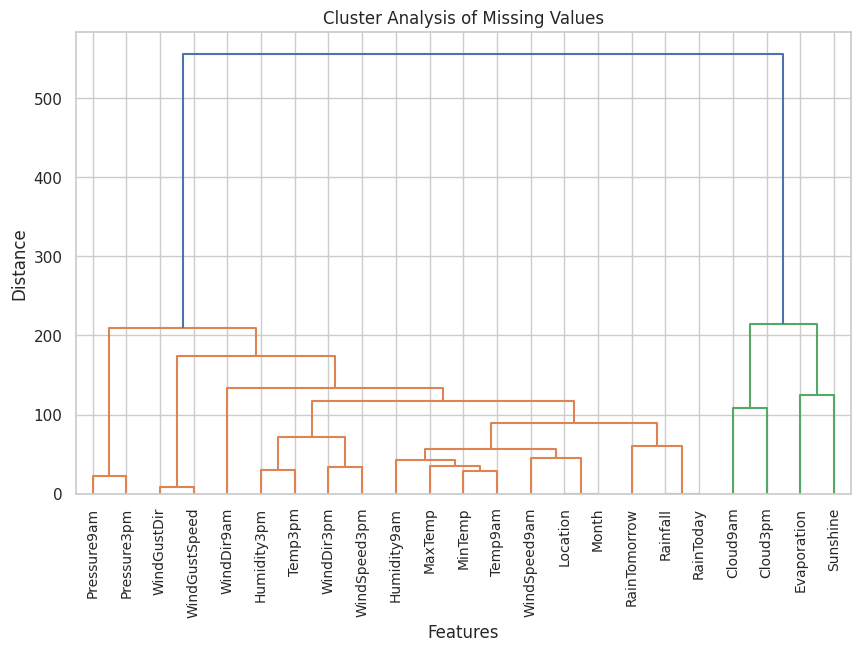

after feature selection:

351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━

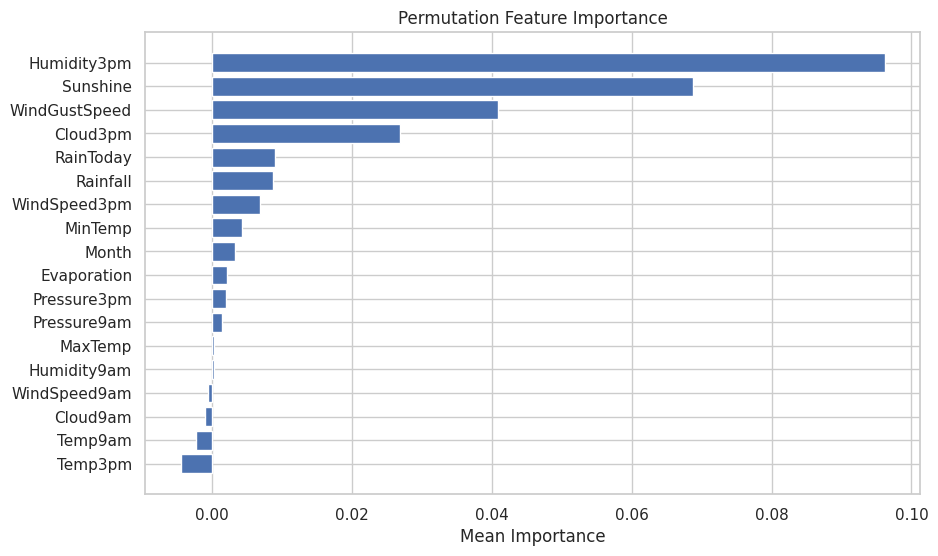

In [80]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# Define a function to evaluate model performance
def model_score(estimator, X, y):
    pred = (estimator.predict(X) > 0.5).astype("int32").flatten()
    return accuracy_score(y, pred)

# Perform permutation feature importance
perm_importance = permutation_importance(ann_model, X_test, y_test, scoring=model_score, n_repeats=10, random_state=0)

# Extract feature names and importance values
feature_names = X_test.columns
importances = perm_importance.importances_mean
sorted_idx = np.argsort(importances)[::-1]  # Sort in descending order

# Display feature importances
print("Permutation Feature Importances:")
for i in sorted_idx:
    print(f"Feature: {feature_names[i]}, Importance: {importances[i]:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Mean Importance")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In [ ]:
# with open('model.pkl', 'wb') as f:
#     pickle.dump(dt_tuned, f)

# Using Confusion Matrix For Predictions

# ANN

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


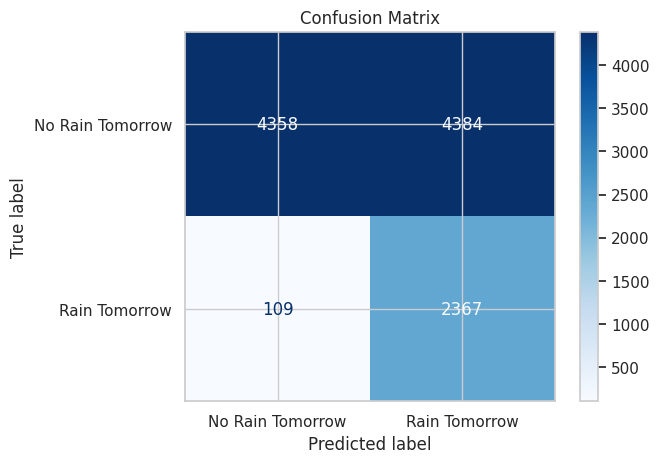

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions
pred = (ann_model.predict(X_test) > 0.5).astype("int32").flatten()

# Create confusion matrix
cm = confusion_matrix(y_test, pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain Tomorrow', 'Rain Tomorrow'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Based on confusion matrix:

Top Left: These are true negatives. There were 4835 times the model predicted no rain, and there was ctually no rain. This means the model predcted dry days correctly for 4835 times.

Top Right: These are the false positives. There are 4384 days the model predicted to have rain when the day was dry, this is not bad as a rainy day was falsely predicted so its just a false alarm.

Bottom Left: These are cases of missed predictions. This is problematic. There are 109 days predicted to not have rain when the day was dry, this is more important. The model failed 109 times.

Bottom Right: These are true positives. The model predicted there will be rain tomorrow, and rain actually fell the next day. The model predicted rain correctly for 2367 times.